In [1]:
!pip install tensorflow keras opencv-python matplotlib

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [2]:
# =======================
# STEP 1: Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# =======================
# STEP 2: Unzip datasets into /content
# =======================
!unzip -q "/content/drive/MyDrive/mri.zip" -d "/content/mri"
!unzip -q "/content/drive/MyDrive/ct.zip" -d "/content/ct"

In [4]:
# =======================
# STEP 3: Verify extraction
# =======================
print("MRI dataset structure:")
!ls "/content/mri"

print("\nCT dataset structure:")
!ls "/content/ct"


MRI dataset structure:
Testing  Training

CT dataset structure:
head_ct  labels.csv


In [5]:
# MRI dataset (ready to use)
MRI_TRAIN_DIR = "/content/mri/Training"
MRI_VAL_DIR   = "/content/mri/Testing"

# CT dataset (images + labels)
CT_IMG_DIR    = "/content/ct/head_ct/head_ct"
CT_LABELS_CSV = "/content/ct/labels.csv"


In [6]:
# =======================
# STEP 5: Verify subfolders (classes)
# =======================
print("MRI Train Classes:")
!ls "$MRI_TRAIN_DIR"

print("\nMRI Val Classes:")
!ls "$MRI_VAL_DIR"

print("\nCT Train Classes:")
!ls "$CT_IMG_DIR"

print("\nCT Val Classes:")
!ls "$CT_LABELS_CSV"


MRI Train Classes:
glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor

MRI Val Classes:
glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor

CT Train Classes:
000.png  023.png  046.png  069.png  092.png  115.png  138.png  161.png	184.png
001.png  024.png  047.png  070.png  093.png  116.png  139.png  162.png	185.png
002.png  025.png  048.png  071.png  094.png  117.png  140.png  163.png	186.png
003.png  026.png  049.png  072.png  095.png  118.png  141.png  164.png	187.png
004.png  027.png  050.png  073.png  096.png  119.png  142.png  165.png	188.png
005.png  028.png  051.png  074.png  097.png  120.png  143.png  166.png	189.png
006.png  029.png  052.png  075.png  098.png  121.png  144.png  167.png	190.png
007.png  030.png  053.png  076.png  099.png  122.png  145.png  168.png	191.png
008.png  031.png  054.png  077.png  100.png  123.png  146.png  169.png	192.png
009.png  032.png  055.png  078.png  101.png  124.png  147.png  170.png	193.png
010.png  033.png  056.png  079.png  102.

In [7]:
import pandas as pd

ct_labels = pd.read_csv("/content/ct/labels.csv")

# Show first 5 rows
print(ct_labels.head())

# Show column names
print("Columns:", ct_labels.columns.tolist())


   id   hemorrhage
0   0            1
1   1            1
2   2            1
3   3            1
4   4            1
Columns: ['id', ' hemorrhage']


In [8]:
import os

# Create a new column with image file paths
ct_labels['filepath'] = ct_labels['id'].astype(str) + ".png"   # or .jpg if images are jpg

# Attach directory
ct_labels['filepath'] = ct_labels['filepath'].apply(lambda x: os.path.join("/content/ct/head_ct", x))

print(ct_labels.head())


   id   hemorrhage                   filepath
0   0            1  /content/ct/head_ct/0.png
1   1            1  /content/ct/head_ct/1.png
2   2            1  /content/ct/head_ct/2.png
3   3            1  /content/ct/head_ct/3.png
4   4            1  /content/ct/head_ct/4.png


In [9]:
print("Columns in CT labels CSV:")
print(ct_labels.columns.tolist())

print("\nFirst 5 rows:")
print(ct_labels.head())


Columns in CT labels CSV:
['id', ' hemorrhage', 'filepath']

First 5 rows:
   id   hemorrhage                   filepath
0   0            1  /content/ct/head_ct/0.png
1   1            1  /content/ct/head_ct/1.png
2   2            1  /content/ct/head_ct/2.png
3   3            1  /content/ct/head_ct/3.png
4   4            1  /content/ct/head_ct/4.png


In [10]:
!pip install albumentations opencv-python


In [11]:
from tensorflow.keras import layers, models, optimizers

def build_small_ct_model(input_shape=(224,224,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

ct_model = build_small_ct_model()
ct_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import albumentations as A

ct_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])


In [13]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import os

class SmallCTDataGenerator(Sequence):
    def __init__(self, df, img_dir, batch_size=16, img_size=(224,224), shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.df))

        self.transform = ct_transform

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        X = []
        y = []
        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row['filename'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)

            if self.augment:
                img = self.transform(image=img)['image']

            X.append(img / 255.0)
            y.append(row['label'])

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

CT_IMG_DIR = "/content/ct/head_ct/head_ct"
ct_labels = pd.read_csv("/content/ct/labels.csv")
ct_labels.columns = ct_labels.columns.str.strip()
ct_labels['label'] = ct_labels['hemorrhage']
ct_labels['filename'] = ct_labels['id'].apply(lambda x: f"{x:03d}.png")
ct_labels = ct_labels[ct_labels['filename'].isin(os.listdir(CT_IMG_DIR))]

train_df, val_df = train_test_split(ct_labels, test_size=0.2, stratify=ct_labels['label'], random_state=42)


In [15]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)

ct_train_gen = SmallCTDataGenerator(train_df, CT_IMG_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=True)
ct_val_gen = SmallCTDataGenerator(val_df, CT_IMG_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False)


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_ct = ct_model.fit(
    ct_train_gen,
    validation_data=ct_val_gen,
    epochs=25,
    callbacks=[lr_reduce, early_stop]
)

ct_model.save("/content/ct_small_cnn.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5359 - loss: 0.7411 - val_accuracy: 0.5000 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5735 - loss: 0.7105 - val_accuracy: 0.7000 - val_loss: 0.6200 - learning_rate: 1.0000e-04
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7008 - loss: 0.6228 - val_accuracy: 0.6250 - val_loss: 0.6051 - learning_rate: 1.0000e-04
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6218 - loss: 0.6164 - val_accuracy: 0.7250 - val_loss: 0.5802 - learning_rate: 1.0000e-04
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6702 - loss: 0.6072 - val_accuracy: 0.6750 - val_loss: 0.6105 - learning_rate: 1.0000e-04
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6801 - loss: 0.5978 - val_accuracy: 0.7250 - val_loss: 0.5680 - learning_rate: 1.0000e-04
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6267 - loss:

In [17]:
import os

def count_images_in_classes(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):  # only look at folders
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
    return class_counts

# Replace with your MRI train and validation directories
print("Training set:")
print(count_images_in_classes(MRI_TRAIN_DIR))

print("\nValidation set:")
print(count_images_in_classes(MRI_VAL_DIR))


Training set:
{'glioma_tumor': 826, 'pituitary_tumor': 827, 'no_tumor': 395, 'meningioma_tumor': 822}

Validation set:
{'glioma_tumor': 100, 'pituitary_tumor': 74, 'no_tumor': 105, 'meningioma_tumor': 115}


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Class weights: {0: 0.8686440677966102, 1: 0.8728710462287105, 2: 1.8164556962025316, 3: 0.8675937122128174}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5081 - loss: 1.1397
Epoch 1: val_accuracy improved from -inf to 0.46954, saving model to mri_effb3_top.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 939s 5s/step - accuracy: 0.5087 - loss: 1.1386 - val_accuracy: 0.4695 - val_loss: 1.2275 - learning_rate: 1.0000e-04
Epoch 2/6
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7562 - loss: 0.6215
Epoch 2: val_accuracy improved from 0.46954 to 0.49746, saving model to mri_effb3_top.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 888s 5s/step - accuracy: 0.7562 - loss: 0.6214 - val_accuracy: 0.4975 - val_loss: 1.1955 - learning_rate: 1.0000e-04
Epoch 3/6
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7958 - loss: 0.5230
Epoch 3: val_accuracy improved from 0.49746 to 0.57868, saving model to mri_effb3_top.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 878s 5s/step - accuracy: 0.7958 - loss: 0.5230 - val_accuracy: 0.5787 - val_loss: 1.1828 - learning_rate: 1.0000e-04
Epoch 4/6
180/180 ━━━━━━━━━━━━━━━━━━━

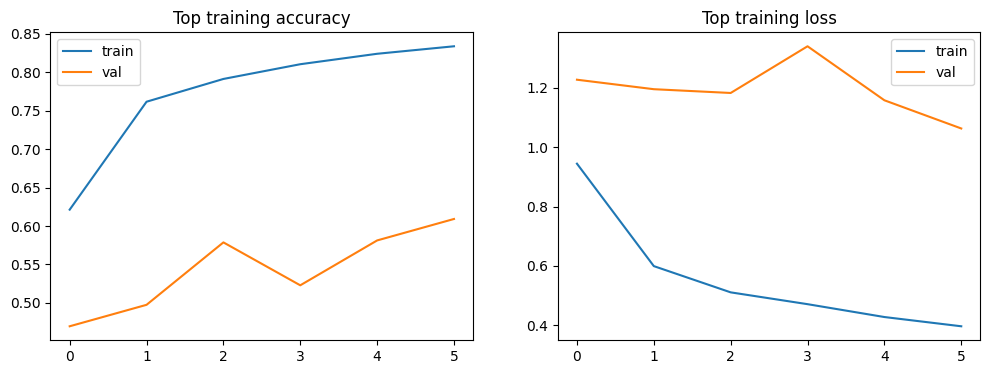

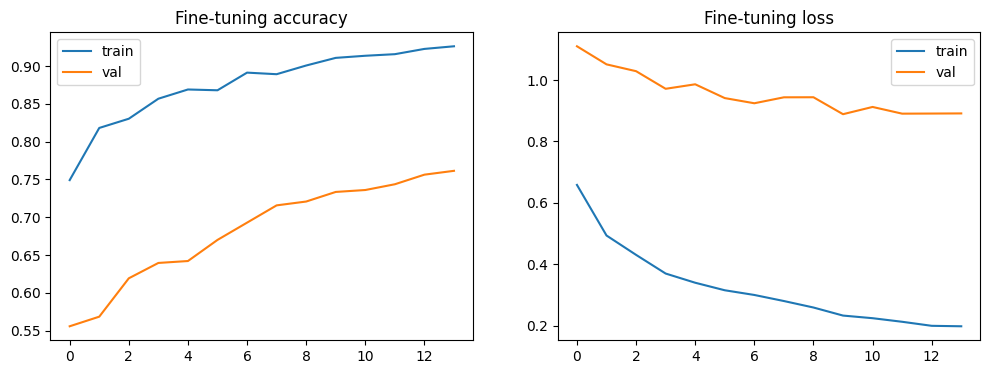

In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

IMG_SIZE = (300,300)
BATCH_SIZE = 16
EPOCHS_TOP = 6
EPOCHS_FINE = 14
MRI_TRAIN_DIR = "/content/mri/Training"
MRI_VAL_DIR = "/content/mri/Testing"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

mri_train_gen = train_datagen.flow_from_directory(
    MRI_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

mri_val_gen = val_datagen.flow_from_directory(
    MRI_VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = mri_train_gen.num_classes
class_indices = mri_train_gen.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}

y_train = mri_train_gen.classes
unique_classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights = {int(cls): float(w) for cls,w in zip(unique_classes, cw)}
print("Class indices:", class_indices)
print("Class weights:", class_weights)

base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)
mri_model = Model(inputs=base.input, outputs=out)
mri_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_top = ModelCheckpoint('mri_effb3_top.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

history_top = mri_model.fit(
    mri_train_gen,
    validation_data=mri_val_gen,
    epochs=EPOCHS_TOP,
    class_weight=class_weights,
    callbacks=[checkpoint_top, lr, es]
)

base.trainable = True
for layer in base.layers[:-60]:
    layer.trainable = False

mri_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_ft = ModelCheckpoint('mri_effb3_finetuned.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history_ft = mri_model.fit(
    mri_train_gen,
    validation_data=mri_val_gen,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=[checkpoint_ft, lr, es]
)

mri_model.save('/content/mri_model_effb3.keras')

mri_model.load_weights('mri_effb3_finetuned.keras')
y_pred_prob = mri_model.predict(mri_val_gen, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = mri_val_gen.classes
target_names = [inv_class_indices[i] for i in range(num_classes)]
print(classification_report(y_true, y_pred, target_names=target_names))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

def plot_history(h, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train')
    plt.plot(h.history['val_accuracy'], label='val')
    plt.title(title + ' accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title(title + ' loss')
    plt.legend()
    plt.show()

plot_history(history_top, 'Top training')
plot_history(history_ft, 'Fine-tuning')
